In [ ]:
import numpy as np
from numpy import real
import math as m
from keras.models import Sequential
from keras.layers import Dense, Layer, RNN, AbstractRNNCell
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import random as rn

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


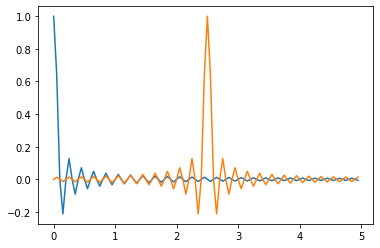

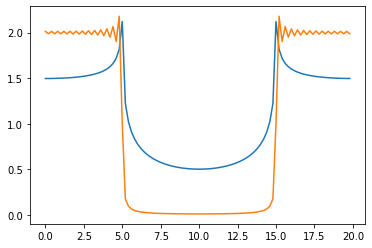

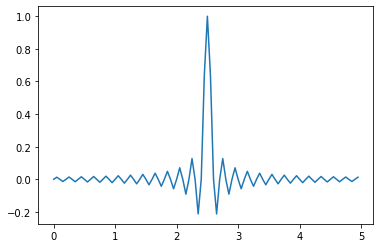

In [ ]:
fs=20
samp=100

timelist=[i/fs for i in range(samp)]
xstart=np.array([np.sinc(10*i) for i in timelist])
xmid=np.array([np.sinc(10*(i-2.5)) for i in timelist])
plt.figure(0)
plt.plot(timelist,xstart,timelist,xmid)

Xfstart=abs(np.fft.fft(xstart))
Xfmid=abs(np.fft.fft(xmid))
freqlist=[i*fs/samp for i in range(samp)]
plt.figure(1)
plt.plot(freqlist,Xfstart,freqlist,Xfmid)

x_mid_reconst=np.fft.ifft(np.fft.fft(xmid))
plt.figure(2)
plt.plot(timelist,x_mid_reconst)

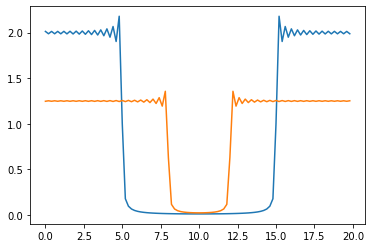

In [ ]:
#Time series first
fs=20
samp=100

timelist=[i/fs for i in range(samp)]
x10=np.array([np.sinc(10*(i-samp/(2*fs))) for i in timelist])
x16=np.array([np.sinc(16*(i-samp/(2*fs))) for i in timelist])

Xfstart=abs(np.fft.fft(x10))
Xfmid=abs(np.fft.fft(x16))
freqlist=[i*fs/samp for i in range(samp)]
plt.figure(0)
plt.plot(freqlist,Xfstart,freqlist,Xfmid)

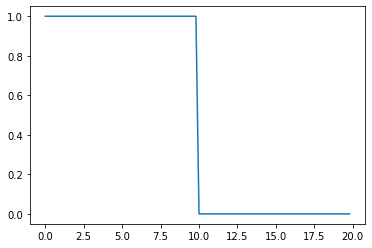

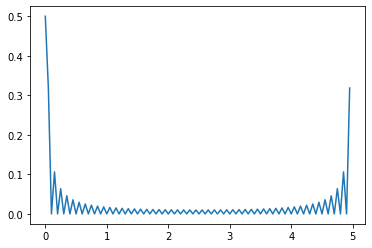

In [ ]:
#comparison not used
fs=20
samp=100

freqlist=[i*fs/samp for i in range(samp)]
rect_spec2=np.array([float(i<len(range(samp))//2) for i in range(samp)])
plt.figure(0)
plt.plot(freqlist,rect_spec2)

timelist=[i/fs for i in range(samp)]
signal=abs(np.fft.ifft(rect_spec2))
plt.figure(1)
plt.plot(timelist,signal)

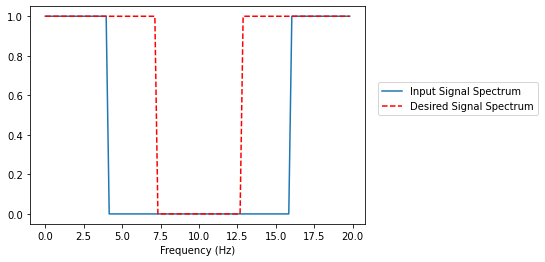

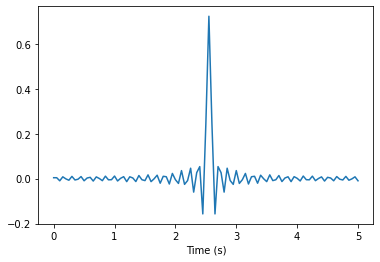

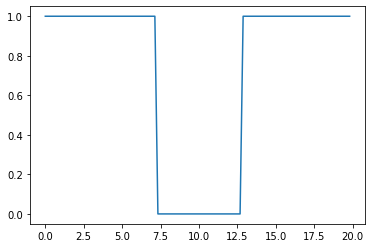

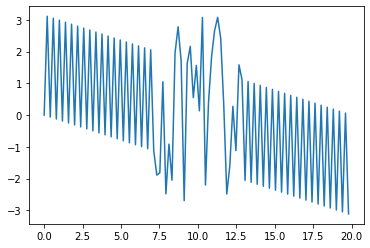

In [ ]:
#Frequency first odd
fs=20
samp=101 #Odd to account for 0 freq term

freqlist=[i*fs/samp for i in range(samp)]
half_spec1=[float(i<36) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec1=np.array([1]+half_spec1+half_spec2)

half_spec1=[float(i<20) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec2=np.array([1]+half_spec1+half_spec2)

plt.figure(0)
plt.plot(freqlist,rect_spec2,label="Input Signal Spectrum")
plt.plot(freqlist,rect_spec1,color='red',linestyle="--", label="Desired Signal Spectrum")
plt.xlabel('Frequency (Hz)')
plt.legend(loc=(1.04,0.5))

timelist=[i/fs for i in range(samp)]
signal=np.fft.ifftshift(np.fft.ifft(rect_spec1)).real
plt.figure(1)
plt.plot(timelist,signal)
plt.xlabel('Time (s)')

reconst_freq=np.fft.fft(signal)
plt.figure(2)
plt.plot(freqlist,abs(reconst_freq))

plt.figure(3)
plt.plot(freqlist,np.angle(reconst_freq))


(1000, 99, 2)
(1000, 99, 2)


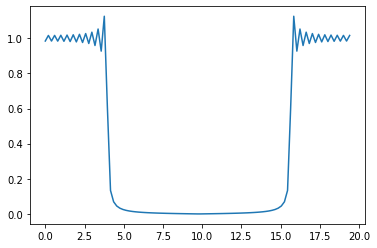

In [ ]:
#Training signals - real in time, frequency built first, ifft shifted
fs=20
samp=101 #Odd to account for 0 freq term
freq_res=101//20
batch_size=1000

freqlist=[i*fs/samp for i in range(samp)]
freqlist2=[i*fs/samp for i in range(samp-2)]
timelist=[i/fs for i in range(samp)]

#inputs
x0=[]
preprocess_weights=np.array([1,2,1])
for k in range(batch_size):
  cut_off_samp=rn.uniform(4*freq_res,9*freq_res)
  half_spec1=[float(i<cut_off_samp) for i in range(samp//2)]
  half_spec2=half_spec1[::-1]
  rect_spec=np.array([1]+half_spec1+half_spec2)

  signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
  processed_signal=np.convolve(preprocess_weights,signal,'valid')
  complex_signal=[[i,0] for i in processed_signal]
  x0.append(complex_signal)

x=np.array(x0)

#desired outputs
half_spec1=[float(i<4*freq_res) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)
signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
cropped_signal=signal[2:]
complex_signal=[[i,0] for i in cropped_signal]

y=np.array([complex_signal for i in range(batch_size)])

print(y.shape)
print(x.shape)

reconst_freq=np.fft.fft(cropped_signal)
plt.figure(2)
plt.plot(freqlist2,abs(reconst_freq))

In [ ]:
class order_1_IIR_RNN(AbstractRNNCell):
  def __init__(self, units, **kwargs):
    self.units=units
    super(order_1_IIR_RNN, self).__init__(**kwargs)

  @property
  def state_size(self):
      return self.units
    
  def build(self, input_shape):
    self.w_rec=self.add_weight(shape=(input_shape[-1],),
                               initializer = 'random_normal',
                               trainable = True,
                               constraint=tf.keras.constraints.MinMaxNorm(min_value=0.0, max_value=1.0))
    self.w_input=self.add_weight(shape=(input_shape[-1],),
                               initializer = 'random_normal',
                               trainable = True)
    self.built=True
    
  def call(self, inputs, states):
    prev_output=states[0]
    im_neg_tensor=tf.constant([[1,0],[0,-1]], dtype=tf.float32, shape=(2,2))
    reverse_axis=tf.constant([0],dtype=tf.int32)
    
    dim_raised_rec_w=tf.stack([self.w_rec])
    im_neg_rec_w=tf.matmul(dim_raised_rec_w, im_neg_tensor)
    W_rec_top=im_neg_rec_w[0]
    W_rec_bottom=tf.reverse(self.w_rec,reverse_axis)
    W_rec=tf.stack([W_rec_top,W_rec_bottom])

    dim_raised_input_w=tf.stack([self.w_input])
    im_neg_input_w=tf.matmul(dim_raised_input_w, im_neg_tensor)
    W_input_top=im_neg_input_w[0]
    W_input_bottom=tf.reverse(self.w_input,reverse_axis)
    W_input=tf.stack([W_input_top,W_input_bottom])

    y=tf.matmul(inputs, W_input)+tf.matmul(prev_output,W_rec)
    return y, [y]


In [ ]:
IIR_cell0 = order_1_IIR_RNN(2)
IIR_layer0 = RNN(IIR_cell0, return_sequences=True)
IIR_cell1 = order_1_IIR_RNN(2)
IIR_layer1 = RNN(IIR_cell1, return_sequences=True)

inputs=tf.keras.Input(shape=(None,2))
x0=IIR_layer0(inputs)
x1=IIR_layer1(x0)
model = tf.keras.Model(inputs=inputs, outputs=x1)
model.compile(loss='MeanSquaredError', optimizer='adam')
print(model.trainable_variables) 


[<tf.Variable 'rnn/order_1_iir_rnn/Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.04339368, -0.08484941], dtype=float32)>, <tf.Variable 'rnn/order_1_iir_rnn/Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.04310922, -0.05823776], dtype=float32)>, <tf.Variable 'rnn_1/order_1_iir_rnn_1/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.07067244,  0.07763816], dtype=float32)>, <tf.Variable 'rnn_1/order_1_iir_rnn_1/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.03975904, -0.08261389], dtype=float32)>]


In [ ]:
model.fit(x,y,batch_size=100,epochs=100,verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 28ms/step - loss: 0.0021
Epoch 2/100
10/10 [==============================] - 0s 33ms/step - loss: 0.0021
Epoch 3/100
10/10 [==============================] - 0s 47ms/step - loss: 0.0021
Epoch 4/100
10/10 [==============================] - 0s 48ms/step - loss: 0.0021
Epoch 5/100
10/10 [==============================] - 0s 49ms/step - loss: 0.0021
Epoch 6/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0021
Epoch 7/100
10/10 [==============================] - 1s 55ms/step - loss: 0.0021
Epoch 8/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0020
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0020
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 0.0020
Epoch 11/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0020
Epoch 12/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0020
Epoch 13/100
10/10 [=====

In [ ]:
print(model.trainable_variables) 

[<tf.Variable 'rnn/order_1_iir_rnn/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.19578281, -0.00039438], dtype=float32)>, <tf.Variable 'rnn/order_1_iir_rnn/Variable:0' shape=(2,) dtype=float32, numpy=array([0.43906376, 0.40097854], dtype=float32)>, <tf.Variable 'rnn_1/order_1_iir_rnn_1/Variable:0' shape=(2,) dtype=float32, numpy=array([-7.3748547e-01,  6.4495835e-04], dtype=float32)>, <tf.Variable 'rnn_1/order_1_iir_rnn_1/Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.4622547, -0.4223846], dtype=float32)>]


[array([6.860785e-02, 9.704159e-05], dtype=float32), array([-0.21693403,  0.23899673], dtype=float32), array([ 6.587664e-01, -4.612359e-05], dtype=float32), array([0.22847266, 0.25876626], dtype=float32), array([-6.9610530e-01, -4.3013974e-06], dtype=float32), array([ 0.280666  , -0.22182615], dtype=float32), array([-0.8034711 , -0.00119272], dtype=float32), array([-0.24726273, -0.19034252], dtype=float32)]
[[(-0.21693402528762817+0.2389967292547226j), (0.06860785186290741+9.704159310786054e-05j)], [(0.22847266495227814+0.2587662637233734j), (0.6587663888931274-4.612359043676406e-05j)]]


Text(0, 0.5, '|H(jw))|')

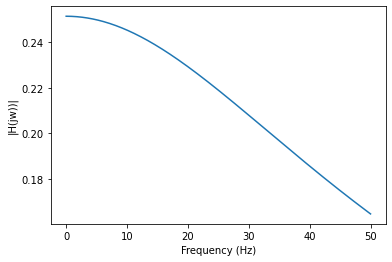

In [ ]:
weights0=model.get_weights()
print(weights0)
T=1/fs
a0=complex(weights0[1][0],weights0[1][1])
a1=complex(weights0[3][0],weights0[3][1])
b0=complex(weights0[0][0],weights0[0][1])
b1=complex(weights0[2][0],weights0[2][1])
weights=[[a0,b0],[a1,b1]]
print(weights)

freqs=np.linspace(0,50,400)

trans=Transfer_Function(weights, freqs, T)
plt.figure(0)
plt.plot(freqs, abs(trans))
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(jw))|')

In [ ]:
def Transfer_Function(weights, freqs, T):
  const_coeff=1
  poles=[]
  for weight in weights:
    a=weight[0]
    b=weight[1]
    const_coeff*=4*a/(T*(1-b))

    pole=2*(1+b)/(T*(1-b))
    poles.append(pole)
  
  transfer_funct=np.ones(len(freqs))
  for pole in poles:
    funct=np.array([1/(complex(0,w)+pole) for w in freqs])
    transfer_funct=transfer_funct*funct
  
  transfer_funct= transfer_funct*const_coeff

  return transfer_funct

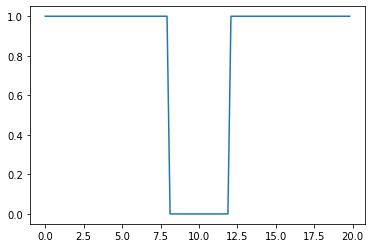

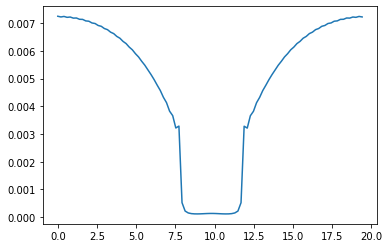

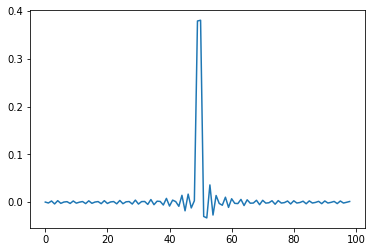

In [ ]:
#Predictions
fs=20
samp=101 #Odd to account for 0 freq term
freq_res=101//20
freq_res2=99//20
batch_size=1000

freqlist=[i*fs/samp for i in range(samp)]
freqlist2=[i*fs/samp for i in range(samp-2)]
timelist=[i/fs for i in range(samp)]

preprocess_weights=np.array([1,2,1])

cut_off_samp=rn.uniform(4*freq_res,9*freq_res)
half_spec1=[float(i<cut_off_samp) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)

plt.figure(0)
plt.plot(freqlist,rect_spec)

signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
processed_signal=np.convolve(preprocess_weights,signal,'valid')
complex_signal=[[i,0] for i in processed_signal]
input=np.array([complex_signal])

rnn_out=model.predict(input)
output=np.array([complex(y[0],y[1]) for y in rnn_out[0]])
output_spectrum=np.fft.ifft(output)

plt.figure(1)
plt.plot(freqlist2, abs(output_spectrum))

plt.figure(2)
plt.plot(output.real)

(1000, 157, 2)
(1000, 157, 2)


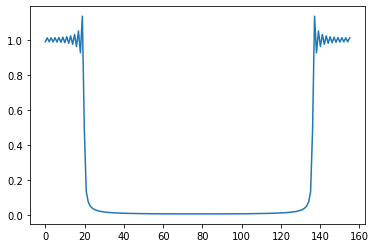

In [ ]:
#Good here
fs=160
samp=161 #Odd to account for 0 freq term
freq_res=161//160
batch_size=1000

freqlist=[i*fs/samp for i in range(samp)]
freqlist2=[i*fs/samp for i in range(samp-4)]
timelist=[i/fs for i in range(samp)]

#inputs
x0=[]
preprocess_weights=np.array([1,4,6,4,1])
for k in range(batch_size):
  height=rn.uniform(1,8)
  cut_off_freq=rn.uniform(20*freq_res,78*freq_res)
  half_spec1=[float(i<20*freq_res)+(height+0*rn.uniform(-0.5,0.5))*float(i>=20*freq_res and i<cut_off_freq) for i in range(samp//2)]
  half_spec2=half_spec1[::-1]
  rect_spec=np.array([1]+half_spec1+half_spec2)

  signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
  processed_signal=np.convolve(preprocess_weights,signal,'valid')
  complex_signal=[[i,0] for i in processed_signal]
  x0.append(complex_signal)

x=np.array(x0)

#desired outputs
half_spec1=[float(i<20*freq_res) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)
signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
cropped_signal=signal[4:]
complex_signal=[[i,0] for i in cropped_signal]

y=np.array([complex_signal for i in range(batch_size)])

print(y.shape)
print(x.shape)

reconst_freq=np.fft.fft(cropped_signal)
plt.figure(2)
plt.plot(freqlist2,abs(reconst_freq))

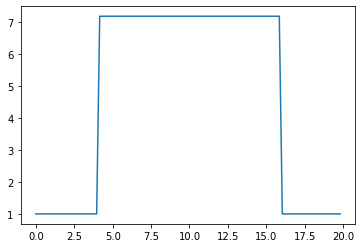

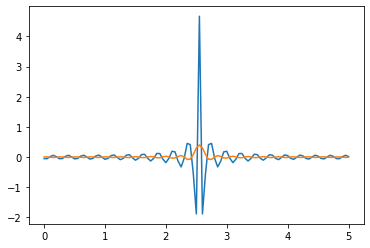

In [ ]:
height=rn.uniform(1,8)
cut_off_freq=rn.uniform(20*freq_res,78*freq_res)
half_spec1=[float(i<20*freq_res)+(height+0*rn.uniform(-0.5,0.5))*float(i>=20*freq_res and i<cut_off_freq) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)
signal0=np.fft.ifftshift(np.fft.ifft(rect_spec)).real

plt.figure(0)
plt.plot(freqlist,rect_spec)

half_spec1=[float(i<20*freq_res) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)
signal1=np.fft.ifftshift(np.fft.ifft(rect_spec)).real


plt.figure(1)
plt.plot(timelist,signal0)
plt.plot(timelist,signal1)

In [ ]:
IIR_cell0 = order_1_IIR_RNN(2)
IIR_layer0 = RNN(IIR_cell0, return_sequences=True)
IIR_cell1 = order_1_IIR_RNN(2)
IIR_layer1 = RNN(IIR_cell1, return_sequences=True)
IIR_cell3 = order_1_IIR_RNN(2)
IIR_layer3 = RNN(IIR_cell3, return_sequences=True)
IIR_cell2 = order_1_IIR_RNN(2)
IIR_layer2 = RNN(IIR_cell2, return_sequences=True)
"""IIR_cell4 = order_1_IIR_RNN(2)
IIR_layer4 = RNN(IIR_cell4, return_sequences=True)
IIR_cell5 = order_1_IIR_RNN(2)
IIR_layer5 = RNN(IIR_cell5, return_sequences=True)"""


inputs=tf.keras.Input(shape=(None,2))
x0=IIR_layer0(inputs)
x1=IIR_layer1(x0)
x2=IIR_layer2(x1)
x3=IIR_layer3(x2)
#x4=IIR_layer4(x3)
#x5=IIR_layer5(x4)


model = tf.keras.Model(inputs=inputs, outputs=x3)
model.compile(loss='MeanSquaredError', optimizer='adam')
print(model.trainable_variables) 

[<tf.Variable 'rnn_2/order_1_iir_rnn_2/Variable:0' shape=(2,) dtype=float32, numpy=array([0.01977562, 0.00782829], dtype=float32)>, <tf.Variable 'rnn_2/order_1_iir_rnn_2/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.00638724,  0.01848983], dtype=float32)>, <tf.Variable 'rnn_3/order_1_iir_rnn_3/Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.02531277, -0.05463494], dtype=float32)>, <tf.Variable 'rnn_3/order_1_iir_rnn_3/Variable:0' shape=(2,) dtype=float32, numpy=array([0.02201032, 0.04836677], dtype=float32)>, <tf.Variable 'rnn_5/order_1_iir_rnn_5/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.01097059, -0.02845669], dtype=float32)>, <tf.Variable 'rnn_5/order_1_iir_rnn_5/Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.07164498, -0.02117809], dtype=float32)>, <tf.Variable 'rnn_4/order_1_iir_rnn_4/Variable:0' shape=(2,) dtype=float32, numpy=array([-0.06329951, -0.03091257], dtype=float32)>, <tf.Variable 'rnn_4/order_1_iir_rnn_4/Variable:0' shape=(2,) dtype=float

In [ ]:
model.fit(x,y,batch_size=100,epochs=80,verbose=1)

Epoch 1/80
10/10 [==============================] - 3s 80ms/step - loss: 8.1073e-04
Epoch 2/80
10/10 [==============================] - 1s 81ms/step - loss: 8.1070e-04
Epoch 3/80
10/10 [==============================] - 1s 80ms/step - loss: 8.1063e-04
Epoch 4/80
10/10 [==============================] - 1s 82ms/step - loss: 8.1047e-04
Epoch 5/80
10/10 [==============================] - 1s 80ms/step - loss: 8.1011e-04
Epoch 6/80
10/10 [==============================] - 1s 79ms/step - loss: 8.0930e-04
Epoch 7/80
10/10 [==============================] - 1s 78ms/step - loss: 8.0759e-04
Epoch 8/80
10/10 [==============================] - 1s 83ms/step - loss: 8.0422e-04
Epoch 9/80
10/10 [==============================] - 1s 79ms/step - loss: 7.9827e-04
Epoch 10/80
10/10 [==============================] - 1s 75ms/step - loss: 7.8922e-04
Epoch 11/80
10/10 [==============================] - 1s 74ms/step - loss: 7.7851e-04
Epoch 12/80
10/10 [==============================] - 1s 78ms/step - loss: 

[array([6.860785e-02, 9.704159e-05], dtype=float32), array([-0.21693403,  0.23899673], dtype=float32), array([ 6.587664e-01, -4.612359e-05], dtype=float32), array([0.22847266, 0.25876626], dtype=float32), array([-6.9610530e-01, -4.3013974e-06], dtype=float32), array([ 0.280666  , -0.22182615], dtype=float32), array([-0.8034711 , -0.00119272], dtype=float32), array([-0.24726273, -0.19034252], dtype=float32)]


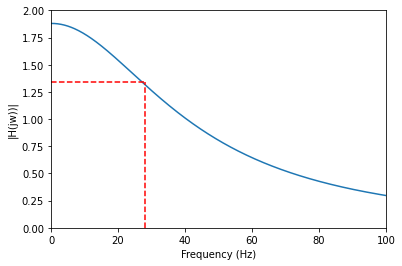

In [ ]:
weights0=model.get_weights()
print(weights0)
T=1/fs
a0=complex(weights0[1][0],weights0[1][1])
a1=complex(weights0[3][0],weights0[3][1])
a2=complex(weights0[5][0],weights0[5][1])
a3=complex(weights0[7][0],weights0[7][1])
#a4=complex(weights0[9][0],weights0[9][1])
#a5=complex(weights0[11][0],weights0[11][1])
b0=complex(weights0[0][0],weights0[0][1])
b1=complex(weights0[2][0],weights0[2][1])
b2=complex(weights0[4][0],weights0[4][1])
b3=complex(weights0[6][0],weights0[6][1])
#b4=complex(weights0[8][0],weights0[8][1])
#b5=complex(weights0[10][0],weights0[10][1])
weights=[[a0,b0],[a1,b1],[a2,b2],[a3,b3]]

freqs=np.linspace(0,100,400)

trans=Transfer_Function(weights, freqs, T)
plt.figure(0)
ax = plt.gca()
ax.set_ylim([0, 2])
ax.set_xlim([0, 100])
plt.plot(freqs, abs(trans))
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(jw))|')

x1=[28,28]
y1=[0,1.34]
x2=[0,28]
y2=[1.34,1.34]
plt.plot(x1,y1,x2,y2,linestyle='--',color="red")

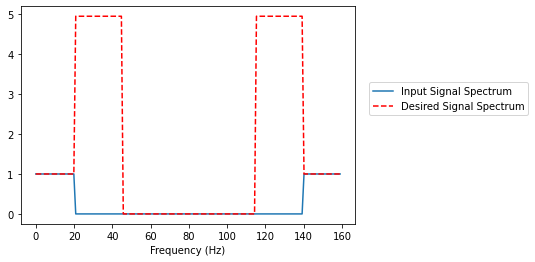

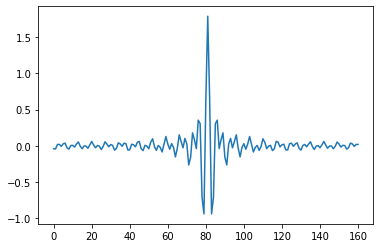

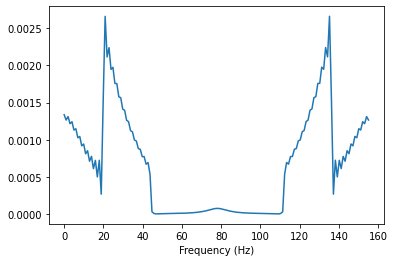

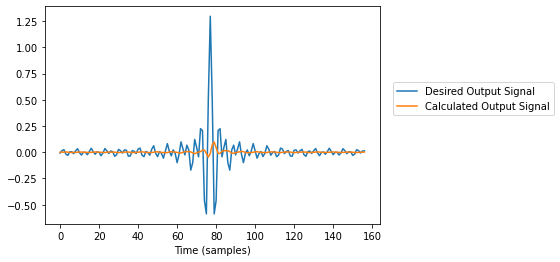

In [ ]:
#Predictions

half_spec1=[float(i<20*freq_res) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec0=np.array([1]+half_spec1+half_spec2)
desired_signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real[4:]

height=rn.uniform(1,8)
cut_off_freq=rn.uniform(20*freq_res,78*freq_res)
half_spec1=[float(i<20*freq_res)+(height+0*rn.uniform(-0.5,0.5))*float(i>=20*freq_res and i<cut_off_freq) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([1]+half_spec1+half_spec2)

plt.figure(0)
plt.plot(freqlist,rect_spec0,label="Input Signal Spectrum")
plt.plot(freqlist,rect_spec,color='red',linestyle="--", label="Desired Signal Spectrum")
plt.xlabel('Frequency (Hz)')
plt.legend(loc=(1.04,0.5))


signal=np.fft.ifftshift(np.fft.ifft(rect_spec)).real
processed_signal=np.convolve(preprocess_weights,signal,'valid')
complex_signal=[[i,0] for i in processed_signal]
input=np.array([complex_signal])
plt.figure(3)
plt.plot(signal)

rnn_out=model.predict(input)
output=np.array([complex(y[0],y[1]) for y in rnn_out[0]])
output_spectrum=np.fft.ifft(output)

plt.figure(1)
plt.plot(freqlist2, abs(output_spectrum), label="Calculated Output Spectrum")
plt.xlabel('Frequency (Hz)')

plt.figure(2)
plt.plot(desired_signal, label="Desired Output Signal")
plt.plot(output.real, label="Calculated Output Signal")
plt.xlabel('Time (samples)')
plt.legend(loc=(1.04,0.5))

In [ ]:
#freq spike alter
fs=160
samp=161 #Odd to account for 0 freq term
freq_res=161//160
batch_size=1000

half_spec1=[50*float(i<30*freq_res) for i in range(samp//2)]
half_spec2=half_spec1[::-1]
rect_spec=np.array([50]+half_spec1+half_spec2)

plt.figure(0)
plt.plot(freqlist,rect_spec)

signal=np.fft.ifft(rect_spec).real
height=rn.uniform(1,2)
noise_freq=rn.uniform(230,300)
signal2=[signal[i]+height*np.cos(i/fs*noise_freq) for i in range(len(signal))]
plt.figure(1)
plt.plot(np.fft.ifftshift(signal2))
plt.plot(np.fft.ifftshift(signal))

recreate_spec=np.fft.ifft(signal2)
plt.figure(2)
plt.plot(freqlist,abs(recreate_spec))